## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №29

#### Выполнить классификацию ттвитов  по эмоциональной окраске из предоставленного набора данных с использованием рекурентных нейронных сетей по 4 классам.
При работе можно использовать пример example_attenchion.ipnyb

In [51]:
import re
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup 

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, pad_sequences
from keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelEncoder

RANDOM_STATE = 42

print('Cuda version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Cuda version: 2.10.1
Num GPUs Available:  1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Загрузить тренировочный и проверочный наборы твитов

In [75]:
colnames=['id', 'network', 'sentiment', 'text'] 

df_train = pd.read_csv('twitter_training.csv', names=colnames, header=None)
df_val = pd.read_csv('twitter_validation.csv', names=colnames, header=None)

df = pd.concat([df_train, df_val])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         75682 non-null  int64 
 1   network    75682 non-null  object
 2   sentiment  75682 non-null  object
 3   text       74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


Выполнить очистку наборов от записей с "пустыми" значениями

In [76]:
df = df.replace(to_replace='None', value=np.nan).dropna()

Построить диаграмму распределения твитов по категориям эмоциональной окраски (Sentiment)

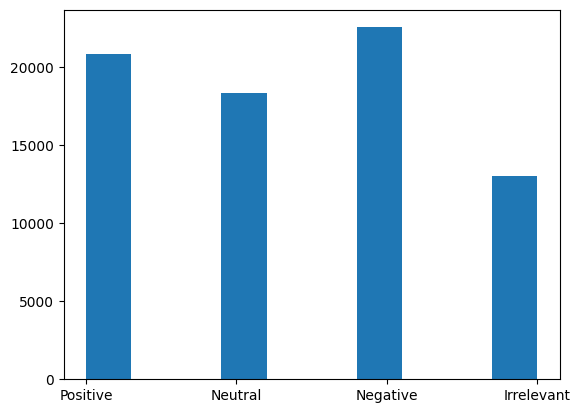

In [79]:
plt.hist(df_train.sentiment)
plt.show()

Выполнить очистку и лемматизацию текста твиттов

In [80]:
STOPWORDS  = stopwords.words('english') + ['im']
STOPWORDS.remove('not')
STOPWORDS.remove('no')

lemmatizer = WordNetLemmatizer()

#### Функция очистки и лемматизации текста
def clean_text(text):
  #очистить текст от тегов html и привести к нижнему регистру
  text = BeautifulSoup(text).get_text().lower()

  #очистить текст от ссылок html
  text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)

  #очистить текст от всех символов кроме букв латинского алфавита
  text = re.sub("[^a-z]", " ", text)

  #разбить текст на слова
  text_words = text.split()

  #выполнить лематизацию текста и удалить стоп-слова
  result_words = [lemmatizer.lemmatize(word) for word in text_words if not word in STOPWORDS]
    
  return (" ".join(result_words))

In [81]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

Кодируем категориальные признаки твиттов

In [84]:
labeles = LabelEncoder()
labels = to_categorical(labeles.fit_transform(df['sentiment']), num_classes=4)

labels.shape

(74996, 4)

Выполняем токенизацию текста для тестового набора твиттов

In [86]:
#максимальное количество слов в твите
TEXT_MAX_LEN = 128
#количество наиболее часто используемых слов
TEXT_MAX_WORDS = 27000

#создать токенайзер
tokenizer = Tokenizer(num_words=TEXT_MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
#создать словарь на основе слов из текста
tokenizer.fit_on_texts(df['text'])
#преобразовать каждый текст в последовательность чисел
sequences = tokenizer.texts_to_sequences(df['text'])


#получим количество уникальных слов
print('Найдено уникальных слов %s'%len(tokenizer.word_index))

Найдено уникальных слов 27065


In [87]:
#преобразуем последовательность индексов слов в массив numpy размером (num_samples, max_len)
texts = pad_sequences(sequences, maxlen=TEXT_MAX_LEN)

print(texts.shape)

(74996, 128)


Перемешиваем обучающий набор данных

In [88]:
#перемешиваем данные
indices = np.arange(texts.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
X = texts[indices]
y = labels[indices]

Создаем обучающий и тестовый наборы данных

In [89]:
TEST_SIZE = 5000

X_test = X[:TEST_SIZE]
y_test = y[:TEST_SIZE]

X_train = X[TEST_SIZE:]
y_train = y[TEST_SIZE:]

Создаем и обучаем модель LSTM

In [149]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=TEXT_MAX_WORDS, output_dim=TEXT_MAX_LEN),
    keras.layers.GRU(units=128, return_sequences=True),
    keras.layers.GRU(units=128),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1024, kernel_initializer='he_normal', activation='ReLU'),
    
    keras.layers.Dense(4, activation='softmax')
])

model.compile(loss= 'categorical_crossentropy', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.01), 
              metrics= ['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_accuracy',
        factor=0.2,
        patience=2
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_LSTM_model.h5',
        monitor = 'val_loss',
        save_Best_only=True
    )
]

print('Model summary:')
print(model.summary())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3456000   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 3,790,340
Trainable params:

In [150]:
#with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, batch_size=1024, epochs=50,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)

print('\nModel history:')
print(history.history.keys())

Epoch 1/50
55/55 [==============================] - 8s 90ms/step - loss: 1.1111 - accuracy: 0.5364 - val_loss: 0.8032 - val_accuracy: 0.6976 - lr: 0.0100
Epoch 2/50
55/55 [==============================] - 4s 79ms/step - loss: 0.5290 - accuracy: 0.8052 - val_loss: 0.4972 - val_accuracy: 0.8187 - lr: 0.0100
Epoch 3/50
55/55 [==============================] - 4s 79ms/step - loss: 0.2662 - accuracy: 0.9015 - val_loss: 0.4526 - val_accuracy: 0.8494 - lr: 0.0100
Epoch 4/50
55/55 [==============================] - 4s 78ms/step - loss: 0.1930 - accuracy: 0.9264 - val_loss: 0.4566 - val_accuracy: 0.8551 - lr: 0.0100
Epoch 5/50
55/55 [==============================] - 4s 79ms/step - loss: 0.2045 - accuracy: 0.9259 - val_loss: 0.7810 - val_accuracy: 0.8061 - lr: 0.0100
Epoch 6/50
55/55 [==============================] - 4s 79ms/step - loss: 0.1698 - accuracy: 0.9382 - val_loss: 0.4674 - val_accuracy: 0.8729 - lr: 0.0020
Epoch 7/50
55/55 [==============================] - 4s 80ms/step - loss: 0.1

In [151]:
print('Метрики на тестовых данных:')
model.evaluate(X_test, y_test)

Метрики на тестовых данных:
157/157 [==============================] - 1s 7ms/step - loss: 0.5993 - accuracy: 0.8740


[0.599272608757019, 0.8740000128746033]

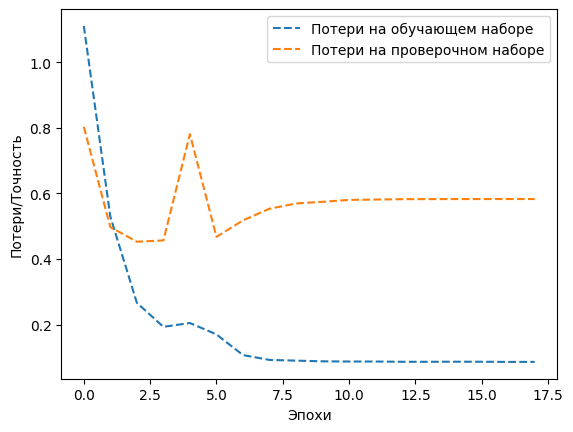

In [152]:
plt.plot(history.history['loss'], linestyle = '--', label='Потери на обучающем наборе')
plt.plot(history.history['val_loss'], linestyle = '--', label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

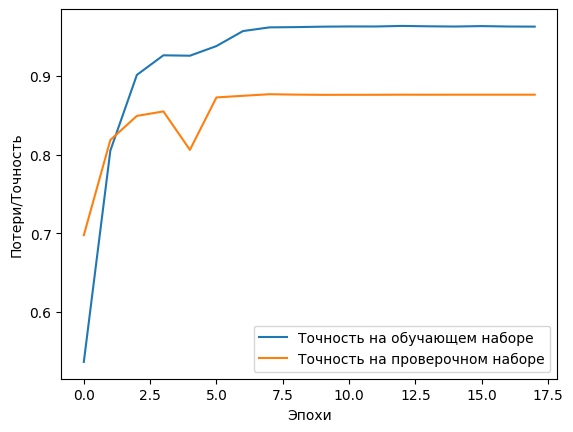

In [153]:
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()